In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from scipy.integrate import odeint 
import time

2024-11-01 08:08:55.341941: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 08:08:55.351957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 08:08:55.362956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 08:08:55.366142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 08:08:55.374593: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_window = 15

def create_inout_sequences(input_data, tw):
    inout_seq = []
    batches,L,dim = (input_data).shape
    for i in range(batches):
        for j in range(L-tw):
            train_seq = input_data[i,j:j+tw,:]
            train_label = input_data[i,j+tw:j+tw+1,:]
            inout_seq.append((train_seq ,train_label))
    return inout_seq

In [4]:
def oscilatorio_simples(x,t,k,m):
    u1 = x[1]
    u0 = x[0]
    return [u1, -k/m*u0]

# Parametros
k = 2.0                   # Constante da mola
m = 1.0                   # Massa
t = np.linspace(0, 10, 101)  # Tempo dt = 0.1

posicoes = np.arange(-10,10,0.5)
velocidades =  np.arange(-5,5,0.5)
solucoes = []
for posicao in posicoes:
    for velocidade in velocidades:
        y0 = [posicao,velocidade]   # Condicoes iniciais: [x0, v0]
        solucao = odeint(oscilatorio_simples, y0, t, args=(k, m))
        solucoes.append(solucao)

solucoes = np.array(solucoes)


inputs_mean = np.mean(solucoes,axis=(0,1))
inputs_std = np.std(solucoes,axis=(0,1))

print(inputs_mean)
print(inputs_std)

inputs_normalizados = (solucoes-inputs_mean)/(inputs_std)

solucoes2 = []
for i in range(5):
    posicao = np.random.uniform(-12,-10)
    velocidade = np.random.uniform(-6,-5)
    y0 = [posicao,velocidade]   # Condicoes iniciais: [x0, v0]
    solucao = odeint(oscilatorio_simples, y0, t, args=(k, m))
    solucoes2.append(solucao)

for i in range(5):
    posicao = np.random.uniform(10,12)
    velocidade = np.random.uniform(6,5)
    y0 = [posicao,velocidade]   # Condicoes iniciais: [x0, v0]
    solucao = odeint(oscilatorio_simples, y0, t, args=(k, m))
    solucoes2.append(solucao)

solucoes2 = np.array(solucoes2)
inputs_normalizados2 = (solucoes2-inputs_mean)/(inputs_std)


sequencias = create_inout_sequences(inputs_normalizados,train_window) 
sequencias_val = create_inout_sequences(inputs_normalizados2,train_window) 
train_inputs = (tf.convert_to_tensor([sequencias[i][0] for i in range(len(sequencias))],dtype=tf.float32))
train_outputs = tf.reshape(tf.convert_to_tensor([sequencias[i][1] for i in range(len(sequencias))],dtype=tf.float32),(-1,2))
val_inputs = (tf.convert_to_tensor([sequencias_val[i][0] for i in range(len(sequencias_val))],dtype=tf.float32))
val_outputs = tf.reshape(tf.convert_to_tensor([sequencias_val[i][1] for i in range(len(sequencias_val))],dtype=tf.float32),(-1,2))




[-0.03199684  0.00787951]
[4.33338883 6.1291414 ]


In [5]:
model_keras = Sequential([
    Input((train_window,2)),
    LSTM(256, return_sequences=1),
    LSTM(128, return_sequences=0),
    (Dense(2))])
model_keras.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,594 (1.76 MB)

 Trainable params: 462,594 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stop = EarlyStopping(monitor="val_loss",patience=150,restore_best_weights=True)

model_keras.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,amsgrad=1), loss='mse',metrics=["mae"])
history = model_keras.fit(train_inputs,train_outputs,validation_data=(val_inputs,val_outputs),epochs=500,batch_size=256*8, verbose = 2,callbacks=early_stop)

Epoch 1/500
34/34 - 2s - 46ms/step - loss: 4.1479e-05 - mae: 0.0041 - val_loss: 0.4888 - val_mae: 0.4685
Epoch 2/500
34/34 - 1s - 15ms/step - loss: 4.1111e-06 - mae: 0.0014 - val_loss: 0.4886 - val_mae: 0.4682
Epoch 3/500
34/34 - 0s - 13ms/step - loss: 2.8936e-06 - mae: 0.0012 - val_loss: 0.4882 - val_mae: 0.4680
Epoch 4/500
34/34 - 0s - 13ms/step - loss: 2.8315e-06 - mae: 0.0011 - val_loss: 0.4880 - val_mae: 0.4679
Epoch 5/500
34/34 - 0s - 13ms/step - loss: 2.8357e-06 - mae: 0.0011 - val_loss: 0.4877 - val_mae: 0.4678
Epoch 6/500
34/34 - 0s - 13ms/step - loss: 2.8412e-06 - mae: 0.0012 - val_loss: 0.4872 - val_mae: 0.4676
Epoch 7/500
34/34 - 0s - 13ms/step - loss: 2.8273e-06 - mae: 0.0012 - val_loss: 0.4868 - val_mae: 0.4672
Epoch 8/500
34/34 - 0s - 13ms/step - loss: 2.9216e-06 - mae: 0.0012 - val_loss: 0.4863 - val_mae: 0.4669
Epoch 9/500
34/34 - 0s - 13ms/step - loss: 3.0066e-06 - mae: 0.0012 - val_loss: 0.4859 - val_mae: 0.4667
Epoch 10/500
34/34 - 0s - 13ms/step - loss: 2.9069e-06 

KeyboardInterrupt: 

In [27]:
tf.keras.models.save_model(model_keras,filepath="modelos_de_verdade/LSTM_oscilatorio_simples.keras")

In [5]:
model_keras = tf.keras.models.load_model("modelos_de_verdade/LSTM_oscilatorio_simples.keras")
model_keras.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,850,378 (7.06 MB)

 Trainable params: 462,594 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,387,784 (5.29 MB)

2024-11-01 08:09:54.183013: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


(201,)
(201,) (201,)
tf.Tensor(0.039039326250704165, shape=(), dtype=float64)


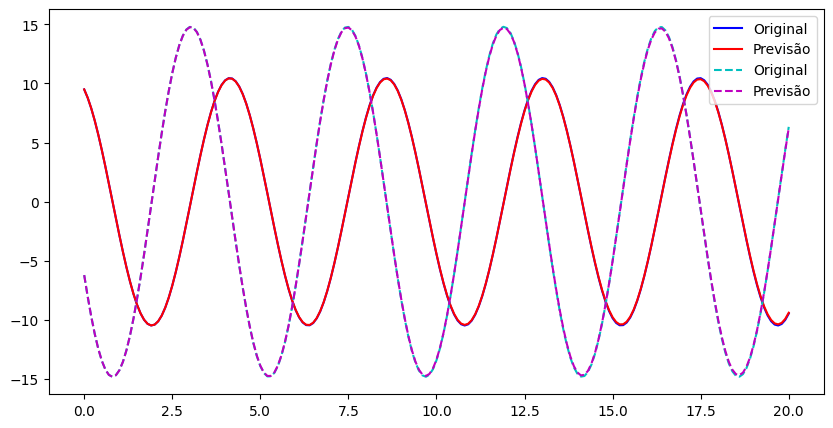

In [6]:
t_final = 20
sol_teste = (odeint(oscilatorio_simples, (9.5,-6.2), np.arange(0,t_final+0.1,0.1), args=(k, m))-inputs_mean)/(inputs_std)
previsoes = (sol_teste[:train_window,:]+0*np.random.normal(size=(train_window,2))).tolist()
for i in range(101-train_window+t_final*10-100):
    prev_temp = model_keras((np.array([previsoes[k] for k in range(i,train_window+i)]).reshape(-1,train_window,2)))
    previsoes.append(prev_temp.numpy().tolist()[0])
previsoes = np.array(previsoes)*inputs_std+inputs_mean
sol_teste= sol_teste*inputs_std+inputs_mean
plt.figure(figsize=(10,5))
x = sol_teste[:,0]
v =  sol_teste[:,1]
x_2 = previsoes[:,0]
print(x.shape)
v_2 = previsoes[:,1]
print(x_2.shape,x.shape)
print(tf.reduce_mean(tf.abs(sol_teste-previsoes)))
n = -1
plt.plot(np.arange(0,t_final+0.1,0.1), x, 'b-', label="Original")
plt.plot(np.arange(0,t_final+0.1,0.1), x_2, 'r-', label="Previsão")
plt.plot(np.arange(0,t_final+0.1,0.1), v, 'c--', label="Original")
plt.plot(np.arange(0,t_final+0.1,0.1), v_2, 'm--', label="Previsão")
plt.legend()
plt.show()

In [27]:
30+16

46

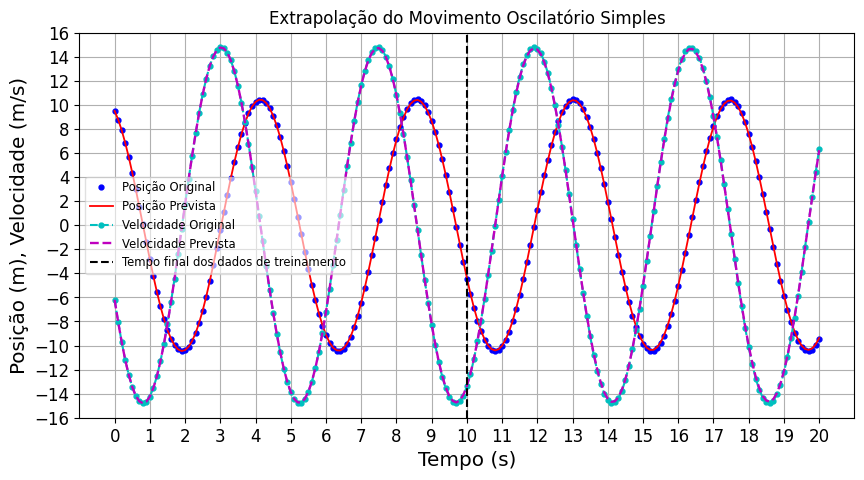

In [24]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,t_final+0.1,0.1), x, 'bo',markersize=3.5, label="Posição Original")
plt.plot(np.arange(0,t_final+0.1,0.1), x_2, 'r-',lw=1.3, label="Posição Prevista")
plt.plot(np.arange(0,t_final+0.1,0.1), v, 'co--',markersize=3.5, label="Velocidade Original")
plt.plot(np.arange(0,t_final+0.1,0.1), v_2, 'm--',lw=1.7, label="Velocidade Prevista")
plt.ylim((-16,16))
plt.yticks(np.linspace(-16,16,17),fontsize="large")
plt.xticks(np.linspace(0,20,21),fontsize="large")
plt.xlabel("Tempo (s)",fontsize="x-large")
plt.ylabel("Posição (m), Velocidade (m/s)",fontsize="x-large")
plt.plot(np.ones(50)*10,np.linspace(-16,18,50),color="black",linestyle="--",label="Tempo final dos dados de treinamento")
plt.title("Extrapolação do Movimento Oscilatório Simples")
plt.grid()
plt.legend(fontsize="small",loc="center left",framealpha=0.6)
plt.savefig("imagens/oscilatorio_simples_banner.png")
plt.show()

In [7]:
def teste(posicoes, velocidades, extrapol, ruido):
    mse = 0
    mae = 0
    mae2 = 0
    cont = 0

    mae_min = 999
    mae_max = 0
    combinacao_min = 0
    combinacao_max = 0

    for position in posicoes:
        for velocity in velocidades:
            t_final = 10 + 5*extrapol
            sol2 = (odeint(oscilatorio_simples, (position,velocity), np.arange(0,t_final+0.1,0.1), args=(k, m)))
            previsoes = ((sol2[:train_window,:]+ruido*np.random.normal(0,0.005 * np.ptp(sol2,axis=0),size=(train_window,2))-inputs_mean)/inputs_std).tolist()
            for i in range(101-train_window+t_final*10-100):
                prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,2)))
                previsoes.append(prev_temp.numpy().tolist()[0])
            previsoes = np.array(previsoes)*inputs_std+inputs_mean
            mse_temp0=(tf.reduce_mean(tf.square(previsoes[train_window+extrapol*(101-train_window):]-sol2[train_window+extrapol*(101-train_window):]),axis=0))
            mae_temp0=(tf.reduce_mean(tf.abs(previsoes[train_window+extrapol*(101-train_window):]-sol2[train_window+extrapol*(101-train_window):]),axis=0))
            mae_temp1=(tf.reduce_mean(tf.abs(previsoes[train_window+extrapol*(101-train_window):]-sol2[train_window+extrapol*(101-train_window):])))
            mse+=mse_temp0
            mae+=mae_temp0
            mae2+=mae_temp1
            cont+=1

            if mae_temp1<=mae_min:
                mae_min = mae_temp1
                combinacao_min = [position,velocity]
            if mae_temp1>=mae_max:
                mae_max= mae_temp1
                combinacao_max = [velocity,velocity]
    
    #tf.print(f"MSE {mse/cont}")
    mae = np.append(mae,mae2)
    with np.printoptions(precision=3):
        tf.print(f"MAE {mae/cont}")
            
    #print(combinacao_max, mae_max)
    #print(combinacao_min,mae_min)
    print()
    

In [8]:
posicoes1 = np.linspace(-12,-10.5,5)
posicoes2 = np.linspace(-10,10,15)
posicoes3 =  np.linspace(12,10.5,5)
velocidades1 = np.linspace(-5,5,10)
velocidades2 = np.append(np.linspace(-7.5,-5.5,5),np.linspace(5.5,7.5,5))


lista_posicoes = [posicoes1,posicoes2,posicoes3]
lista_velocidades = [velocidades1,velocidades2]

print("Sem Nada")
print()
cont_velocidade = 1
cont_posicao = 1
for velocidades in lista_velocidades:
    cont_posicao = 1
    for posicoes in lista_posicoes:
        print(f"V{cont_velocidade} P{cont_posicao}")
        teste(posicoes,velocidades,extrapol=False,ruido=False)
        cont_posicao +=1
    cont_velocidade+=1
print("Extrapolação")
print()
cont_velocidade = 1
cont_posicao = 1
for velocidades in lista_velocidades:
    cont_posicao = 1
    for posicoes in lista_posicoes:
        print(f"V{cont_velocidade} P{cont_posicao}")
        teste(posicoes,velocidades,extrapol=True,ruido=False)
        cont_posicao +=1
    cont_velocidade+=1
print("Ruído")
print()

cont_velocidade = 1
cont_posicao = 1
for velocidades in lista_velocidades:
    cont_posicao = 1
    for posicoes in lista_posicoes:
        print(f"V{cont_velocidade} P{cont_posicao}")
        teste(posicoes,velocidades,extrapol=False,ruido=True)
        cont_posicao +=1
    cont_velocidade+=1

Extrapolação

V1 P1
MAE [0.179 0.261 0.22 ]

V1 P2
MAE [0.01  0.015 0.012]

V1 P3
MAE [0.179 0.26  0.22 ]

V2 P1
MAE [0.314 0.453 0.384]

V2 P2
MAE [0.02  0.029 0.024]

V2 P3
MAE [0.313 0.453 0.383]

Ruído

V1 P1
MAE [0.082 0.123 0.102]

V1 P2
MAE [0.014 0.02  0.017]

V1 P3
MAE [0.083 0.125 0.104]

V2 P1
MAE [0.148 0.219 0.183]

V2 P2
MAE [0.022 0.031 0.027]

V2 P3
MAE [0.143 0.212 0.177]

